In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from tqdm import tqdm

from Chempy.parameter import ModelParameters

import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

import multiprocessing as mp

In [2]:
name = "NPE_C"

In [3]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [4]:
# ----- Load posterior -----
with open(f'data/posterior_{name}.pickle', 'rb') as f:
    posterior = pickle.load(f)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/export/home/bguenes/envs/master_chempy_multi/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

In [5]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
model = Model_Torch()
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval();

/tmp/ipykernel_2339254/3901098474.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))


# Setup priors
The inputs to the model are drawn from a fixed set of global galaxy parameters (slope of the IMF & Rate of Type Ia Supernove) and a set of local star parameters.

In [6]:
local_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

global_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[:2]],
    validate_args=False)

# Simulate data
With the set global priors and for each $N_{\rm stars}$ a set of local priors, we can simulate the data with the Neural Network.

In [7]:
N_stars = 1000
simulations = 1000

stars = local_GP.sample((N_stars,))
global_params = torch.tensor([[-2.3, -2.89]])

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

In [8]:
# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)  
# Remove H from data, because it is just used for normalization (output with index 2)
abundances = torch.cat([abundances[:,0:2], abundances[:,3:]], axis=1)
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 1000 stars: 0.009 s


# SBI with 5% observation error noise
Need to load the posterior trained with a 5% observation error

In [9]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [10]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 1000

start = t.time()
for i in tqdm(range(len(abundances))):
    x = add_noise(abundances[i].detach().numpy())
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_obs.append(alpha)
    log10_N_Ia_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_obs = np.array(alpha_IMF_obs)
log10_N_Ia_obs = np.array(log10_N_Ia_obs)

100%|██████████| 1000/1000 [00:05<00:00, 197.58it/s]

Time to run 1000 simulations for 1000 stars: 5.065 s


In [11]:
# save the data
np.save(f'data/alpha_IMF_obs_{name}.npy', alpha_IMF_obs)
np.save(f'data/log10_N_Ia_obs_{name}.npy', log10_N_Ia_obs)

In [12]:
alpha_IMF_obs.shape

(1000, 1000)

In [13]:
alpha_IMF_obs[0].mean()

-2.2582223

In [14]:
mu_alpha, sigma_alpha = alpha_IMF_obs.mean(axis=1), alpha_IMF_obs.std(axis=1)
mu_N_Ia, sigma_N_Ia = log10_N_Ia_obs.mean(axis=1), log10_N_Ia_obs.std(axis=1)

In [37]:
mu_alpha_combined = np.sum(mu_alpha/sigma_alpha**2)/np.sum(1/sigma_alpha**2)
sigma_alpha_combined = 1/np.sqrt(np.sum(1/sigma_alpha**2))

In [38]:
mu_alpha_combined, sigma_alpha_combined

(-2.2941186, 0.008960796583313457)

In [29]:
x_alpha = np.linspace(-3, -2, 1000)
x_N_Ia = np.linspace(-3, -2, 1000)

In [30]:
log_pdf_alpha = np.zeros_like(x_alpha)
log_pdf_N_Ia = np.zeros_like(x_N_Ia)

for i in range(len(mu_alpha)):
    y_alpha = norm.logpdf(x_alpha, mu_alpha[i], sigma_alpha[i])
    y_N_Ia = norm.logpdf(x_N_Ia, mu_N_Ia[i], sigma_N_Ia[i])

    log_pdf_alpha += y_alpha
    log_pdf_N_Ia += y_N_Ia

In [31]:
x_alpha[log_pdf_alpha.argmax()], x_N_Ia[log_pdf_N_Ia.argmax()]

(-2.2942942942942945, -2.883883883883884)

In [42]:
mu_alpha_combined, sigma_alpha_combined

(-2.2941186, 0.008960796583313457)

In [32]:
alpha_IMF_obs.mean(), log10_N_Ia_obs.mean()

(-2.2936087, -2.8843515)

In [33]:
alpha_IMF_obs.std()/np.sqrt(len(alpha_IMF_obs)), log10_N_Ia_obs.std()/np.sqrt(len(log10_N_Ia_obs))

(0.009044693183651593, 0.010271135786989079)

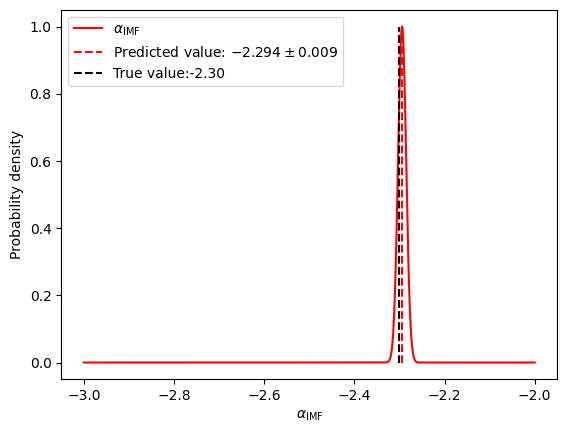

In [48]:
#plt.plot(x_alpha, np.exp(log_pdf_alpha- log_pdf_alpha.max()), label=r'$\alpha_{\rm IMF}$', color='b')
plt.plot(x_alpha, norm.pdf(x_alpha, mu_alpha_combined, sigma_alpha_combined)/norm.pdf(mu_alpha_combined, mu_alpha_combined, sigma_alpha_combined), label=r'$\alpha_{\rm IMF}$', color='r')
plt.vlines(x_alpha[log_pdf_alpha.argmax()], 0, 1, linestyle='--', label=rf'Predicted value: ${mu_alpha_combined:.3f} \pm {sigma_alpha_combined:.3f}$', color='r')  
plt.vlines(global_params[0,0], 0, 1, color='k', linestyle='--', label=r'True value:{:.2f}'.format(global_params[0,0]))  

#plt.plot(x_alpha, norm.pdf(x_alpha, alpha_IMF_obs.mean(), alpha_IMF_obs.std()/np.sqrt(len(alpha_IMF_obs)))/norm.pdf(alpha_IMF_obs.mean(), alpha_IMF_obs.mean(), alpha_IMF_obs.std()/np.sqrt(len(alpha_IMF_obs))), label=r'mean of means', color='r')


plt.xlabel(r'$\alpha_{\rm IMF}$')
plt.ylabel('Probability density')
plt.legend()
plt.show()

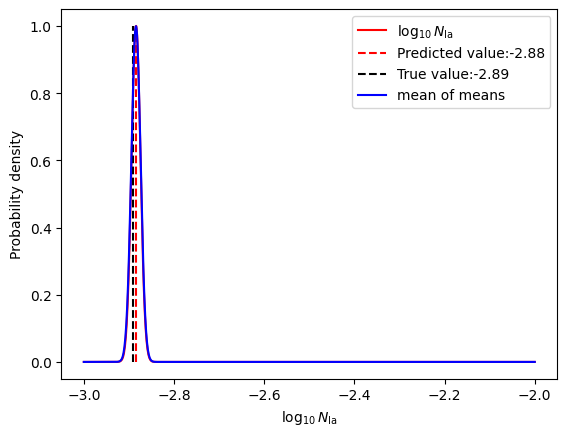

In [35]:
plt.plot(x_N_Ia, np.exp(log_pdf_N_Ia- log_pdf_N_Ia.max()), label=r'$\log_{10} N_{\rm Ia}$', color='r')
plt.vlines(x_N_Ia[log_pdf_N_Ia.argmax()], 0, 1, color='r', linestyle='--', label=r'Predicted value:{:.2f}'.format(x_N_Ia[log_pdf_N_Ia.argmax()]))
plt.vlines(global_params[0,1], 0, 1, color='k', linestyle='--', label=r'True value:{:.2f}'.format(global_params[0,1]))

plt.plot(x_N_Ia, norm.pdf(x_N_Ia, log10_N_Ia_obs.mean(), log10_N_Ia_obs.std()/np.sqrt(len(log10_N_Ia_obs)))/norm.pdf(log10_N_Ia_obs.mean(), log10_N_Ia_obs.mean(), log10_N_Ia_obs.std()/np.sqrt(len(log10_N_Ia_obs))), label=r'mean of means', color='b')

plt.xlabel(r'$\log_{10} N_{\rm Ia}$')
plt.ylabel('Probability density')
plt.legend()
plt.show()